# Preprocessing: removing images

The exploratory data analysis revealed that we are working with compressed image files whose quality varies: some of the images are so dark that it is impossible to determine if they are actually faces.

The analysis also revealed that there are 2400 duplicate images (with 1314 images that should be dropped).

In this notebook, I will remove duplicate and low quality images from the training set. 

I will also create a separate test and validation dataset (we currently only have test and train). I will also check these test/validation datasets to make sure they don't have the same problems and resolve any issues that may arise.


In [29]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from PIL.ExifTags import TAGS
import imagehash
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-01-16 10:16:55.742614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Evalute Images

In [27]:
def get_noise_score(img, width, height):
    """
    Calculate the standard deviation of pixel values.
    
    This function divides the image into smaller windows and calculate the standard deviation
    of the pixel values. With the idea that noisy regions are those with higher 
    standard deviation compared to clean areas.
    """
    noise_score = 0
    window_size = 16

    img_array = np.array(img)
    
    for y in range(0, height - window_size, window_size):
        for x in range(0, width - window_size, window_size):
            window = img_array[y:y+window_size, x:x+window_size]
            window_std = np.std(window)
            noise_score += window_std

    return noise_score / (height * width)
    
    
def evaluate_images(data_path):
    """
    Retrieve noise and hash_value of each image along with basic metadata (file_name, file_path, category)

    Args:
        data_path: (str) path to the category folders containing images that fall under that category
        
    Returns:
        list of dictionaries, each containing metadata about the image
    
    """
    
    file_meta = []
    

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)
        
            with Image.open(image_filepath) as img:
                width, height = img.size

                attrs = {
                    'category': name,
                    'file_name': image_file_name,
                    'file_path': image_filepath,
                    'noise_score': get_noise_score(img, width, height),
                    'hash_value': str(imagehash.phash(img))
                }
                file_meta.append(attrs)
    

    
    return file_meta 

def load_print_images(file_paths):
    """Print out the images found at the given filepaths"""
    for image_path in file_paths:
        img = load_img(image_path)
        display(img)

In [8]:
train_data_folder = "../data/FER-2013/train/"

train_overview = evaluate_images(train_data_folder)

df_overview_train = pd.DataFrame(train_overview)
df_overview_train.head()

,category,file_name,file_path,noise_score,hash_value
0,happy,Training_50449107.jpg,../data/FER-2013/train/happy/Training_50449107...,0.072168,84f817c1b63f186b
1,happy,Training_70433018.jpg,../data/FER-2013/train/happy/Training_70433018...,0.044953,eac1ebc2b13c65e0
2,happy,Training_85610005.jpg,../data/FER-2013/train/happy/Training_85610005...,0.055432,80e85fe7702659ae
3,happy,Training_4460748.jpg,../data/FER-2013/train/happy/Training_4460748.jpg,0.049047,880905f785de45bf
4,happy,Training_6312930.jpg,../data/FER-2013/train/happy/Training_6312930.jpg,0.075139,e8902b2bd2d3d4cb


In [11]:
len(df_overview_train)

28709

## 1. Removing Duplicates from Training dataset

During our EDA, we saw that perceptual hashing was a good way of identifying duplicate images. We will use the same approach here.

In [59]:
def get_duplicates(dframe):
    """Identify all the duplicate images by finding images with the same hash values"""
    duplicates = dframe.groupby(['hash_value']).filter(lambda x: len(x) > 1)
    duplicates = duplicates.sort_values(by="hash_value")
    return duplicates

def get_duplicate_counts(dframe):
    """Get the count of all duplicate images and the number of images that should be dropped"""
    duplicate_no = len(get_duplicates(dframe))
    duplicates_to_drop_no = len(dframe[dframe.duplicated(subset='hash_value')])
    return duplicate_no, duplicates_to_drop_no
    

In [60]:
duplicates_train = get_duplicates(df_overview_train)
len(duplicates_train)

2400

In [63]:
duplicates_train.tail()

,category,file_name,file_path,noise_score,hash_value
14720,fear,Training_49198048.jpg,../data/FER-2013/train/fear/Training_49198048.jpg,0.097149,ff9fe0b0d2290a45
12841,fear,Training_27746315.jpg,../data/FER-2013/train/fear/Training_27746315.jpg,0.097149,ff9fe0b0d2290a45
14144,fear,Training_12587825.jpg,../data/FER-2013/train/fear/Training_12587825.jpg,0.058649,ffa87692895c3582
18983,surprise,Training_63470176.jpg,../data/FER-2013/train/surprise/Training_63470...,0.058649,ffa87692895c3582
14336,fear,Training_70012504.jpg,../data/FER-2013/train/fear/Training_70012504.jpg,0.058649,ffa87692895c3582


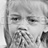

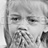

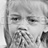

In [64]:
load_print_images(duplicates_train.tail(3)["file_path"].values)

In [65]:
train_dupes_no, train_to_drop_no = get_duplicate_counts(df_overview_train)
train_dupes_no, train_to_drop_no

(2400, 1314)

In [66]:
expected_new_train_length = len(df_overview_train) - train_to_drop_no
expected_new_train_length

27395

In [67]:
df_overview_train = df_overview_train.drop_duplicates(subset=['hash_value'])
len(df_overview_train)

27395

## Preprocessing the test dataset

### Extracting the validation dataset

We do not have a validation dataset.

The dataset was downloaded from [kaggle](https://www.kaggle.com/datasets/msambare/fer2013/data) and derived from a [2013 Facial Recognition Kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

According to the description on kaggle there are 28,709 images in the training set and 3,589 in the "public test set". We can see that we actually have 7178 and that the file names make it clear that the test dataset is divided into "PrivateTest" and "PublicTest". 

We can use this differentiation to create the test and validation datasets. Each contain 3,589 image files.

In [9]:
test_data_folder = "../data/FER-2013/test/"

test_overview = evaluate_images(test_data_folder)

df_overview_test = pd.DataFrame(test_overview)
df_overview_test.head()

,category,file_name,file_path,noise_score,hash_value
0,happy,PrivateTest_45699463.jpg,../data/FER-2013/test/happy/PrivateTest_456994...,0.067485,d10d08b5676c3f96
1,happy,PrivateTest_61855708.jpg,../data/FER-2013/test/happy/PrivateTest_618557...,0.061334,95536934c5bace52
2,happy,PublicTest_53681781.jpg,../data/FER-2013/test/happy/PublicTest_5368178...,0.061739,dcb86296853c693b
3,happy,PrivateTest_52109800.jpg,../data/FER-2013/test/happy/PrivateTest_521098...,0.040864,958c56109b643fd7
4,happy,PublicTest_41104919.jpg,../data/FER-2013/test/happy/PublicTest_4110491...,0.076038,93c84ac3993d69c7


In [12]:
len(df_overview_test)

7178

In [40]:
is_public = df_overview_test["file_name"].str.contains("PublicTest")
df_validation = df_overview_test[is_public]

df_validation.head(2)

,category,file_name,file_path,noise_score,hash_value
2,happy,PublicTest_53681781.jpg,../data/FER-2013/test/happy/PublicTest_5368178...,0.061739,dcb86296853c693b
4,happy,PublicTest_41104919.jpg,../data/FER-2013/test/happy/PublicTest_4110491...,0.076038,93c84ac3993d69c7


In [19]:
df_test = df_overview_test[~is_public]
df_test.head(2)

,category,file_name,file_path,noise_score,hash_value
0,happy,PrivateTest_45699463.jpg,../data/FER-2013/test/happy/PrivateTest_456994...,0.067485,d10d08b5676c3f96
1,happy,PrivateTest_61855708.jpg,../data/FER-2013/test/happy/PrivateTest_618557...,0.061334,95536934c5bace52


In [20]:
len(df_validation), len(df_test)

(3589, 3589)

### Cleaning the test and validation set

Before we separate out our validation and test set, I want to make sure the test dataset doesn't have the same problems encountered in our training dataset.

1. Duplicates

Ideally the test dataset does not contain duplicates. Duplicates could artifically inflate model performance so I want to make sure there are none in the dataset.

2. Low Quality Images

While I don't want to over-clean the test dataset, it should represent images the algorithm finds in reality. Ideally any application should be able to warn users when an image is low quality and reject it rather than pass it to the image classifier. 

### 1. Removing Test and Validation Duplicates

Analysis below shows that we do have duplicate images in our training and validation datasets but the number is quite small so we will just drop them

**Validation**

In [44]:
duplicates_val = get_duplicates(df_validation)
len(duplicates_val)

56

In [45]:
duplicates_val.tail()

,category,file_name,file_path,noise_score,hash_value
4269,surprise,PublicTest_42347603.jpg,../data/FER-2013/test/surprise/PublicTest_4234...,0.073366,fed53a86c86928b1
3511,fear,PublicTest_26755252.jpg,../data/FER-2013/test/fear/PublicTest_26755252...,0.075853,ff075657583c28c2
7108,disgust,PublicTest_75786377.jpg,../data/FER-2013/test/disgust/PublicTest_75786...,0.076655,ff075657583c28c2
3784,fear,PublicTest_72816882.jpg,../data/FER-2013/test/fear/PublicTest_72816882...,0.097149,ff9fe0b0d2290a45
3338,fear,PublicTest_95508061.jpg,../data/FER-2013/test/fear/PublicTest_95508061...,0.097149,ff9fe0b0d2290a45


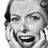

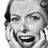

In [46]:
load_print_images(duplicates_val.tail(2)["file_path"].values)

In [53]:
val_dupes_no, val_to_drop_no = get_duplicate_counts(df_validation)
val_dupes_no, val_to_drop_no

(56, 28)

In [55]:
expected_new_val_length = len(df_validation) - val_to_drop_no
expected_new_val_length

3561

In [57]:
df_validation = df_validation.drop_duplicates(subset=['hash_value'])
len(df_validation)

3561

**Test**

In [47]:
duplicates_test = get_duplicates(df_test)
len(duplicates_test)

41

In [48]:
duplicates_test.tail()

,category,file_name,file_path,noise_score,hash_value
3051,fear,PrivateTest_4712911.jpg,../data/FER-2013/test/fear/PrivateTest_4712911...,0.054162,d00952f52f341dd7
4241,surprise,PrivateTest_34688181.jpg,../data/FER-2013/test/surprise/PrivateTest_346...,0.046699,dfd03a14a687f18a
4468,surprise,PrivateTest_26572350.jpg,../data/FER-2013/test/surprise/PrivateTest_265...,0.046699,dfd03a14a687f18a
6686,angry,PrivateTest_37769125.jpg,../data/FER-2013/test/angry/PrivateTest_377691...,0.043474,e2a893e5883efd03
6998,angry,PrivateTest_41308674.jpg,../data/FER-2013/test/angry/PrivateTest_413086...,0.042901,e2a893e5883efd03


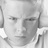

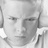

In [49]:
load_print_images(duplicates_test.tail(2)["file_path"].values)

In [54]:
test_dupes_no, test_to_drop_no = get_duplicate_counts(df_test)
test_dupes_no, test_to_drop_no

(41, 21)

In [56]:
expected_new_test_length = len(df_test) - test_to_drop_no
expected_new_test_length

3568

In [58]:
df_test = df_test.drop_duplicates(subset=['hash_value'])
len(df_test)

3568